# Изучение особенностей классических операций работы с изображениями в `PyTorch`

## Импорт 

Часто в условиях предобработки данных для решения задач компьютерного зрения необходимым оказывается проведение классических операций обработки изображений. Такие операции относятся к низкому уровню абстракции решения соответствующих задач. Предобработка позволяет преобразовать изображения к нужному размеру, провести искусственное расширение набора данных или повысить качество примеров данных. Иногда также предобработка необходима для создания особых режимов обучения нейронных сетей. 

Более того понимание работы некоторых классических методов работы с изображениями будет полезным для дальнейшего понимания особенностей работы с сверточными нейронными сетями.

<!-- Как уже говорилось ранее модуль `torch.nn` содержит основные элементы для построения архитектур в рамках фреймворка `PyTorch`. 
Модуль предоставляет два типа API в классовом и процедурном стилях (подмодуль `torch.nn.functional`). В том числе модуль включает основные типы слоев нейронных сетей и основные функции активации и регуляризации.  -->

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [8]:
import torch.nn.functional as F
import torchvision
import torch
from torch import nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

Для начала воспользуемся функцией `read_image` из модуля `torchvision.io` для загрузки произвольного изображения  в виде тензора в формате `PyTorch`. Для загрузки изобажения из интернета воспользуемся библиотекой `urllib`.

In [10]:
!ls

'01 Введение в компьютерное зрение.pptx'
'02 Понятие признак изображения.pptx'
'03 Классические методы решения задач компьютерного зрения.pptx'
'04 Принципы работы сверточных нейронных сетей.pptx'
'05 Современное состояние сверточных нейронных сетей.pptx'
'06 Сети на основе архитектур трансформеров.pptx'
'07 Задача семантической сегментации.pptx'
'08 Задача обнаружения объектов.pptx'
'09 Генеративные подходы в решении задач компьютерного зрения.pptx'
 data
 image1.jpg
 image1.png
 image2.png
 loader
 out.jpg
 README.md
'simple classification'
 WS1_Classic_into_PyTorch.ipynb
 WS1.zip
 WS2_Augment_CNNLayer.ipynb
 WS3_LeNet.ipynb
 WS4_Make_CNN_Better.ipynb
'WS5_Tricks_in_Training CNN.ipynb'
 WS6_PyTorch_transfer.ipynb
'WS7_Semantic Segmentation.ipynb'
'WS8_YOLOv8 API.ipynb'
'WS9 - Hugging Face.ipynb'


In [16]:
import urllib.request

# image_url = 'https://github.com/MVRonkin/Deep-Learning-Foundation-Course/blob/main/2024/data/01.png?raw=true'
# urllib.request.urlretrieve(image_url,"image.png");

image = torchvision.io.read_image("image1.jpg")[:]#.unsqueeze(0)
print(image.shape)

torch.Size([3, 1024, 1024])


Обратите внимание, что для того, чтобы визуализровать изображение нам потребуется поменять разерности, так, как это показано ниже.
```python
    img_ = image.data.numpy().transpose((1,2,0))
```
запишем эти операции в функции `axplot`

In [17]:
def axplot(image, ax=None, title='', standardize = False, equlize = True, **kwargs):
    ''' kwargs: figsize:(int,int); rows_cols:(int,int); finish:bool; ret_ax:bool'''
    
    with torch.inference_mode():
        image_ = torch.as_tensor(image).type(torch.uint8)
        
        if equlize:
            image_ = torchvision.transforms.functional.equalize(image_)
        
        image_ = image_.cpu().detach().numpy()
        image_ = image_.transpose(1,2,0)
    
    
    image_ = np.array(image_)
    
    if standardize:
        image_ = np.copy(image).astype(float)
        image_ = 255*(image_ - image_.min())/(image_.max()-image_.min())
        image_ = image_.astype(np.uint8)

    if ax is None:
        figsize   = (3,3) if kwargs.get('figsize')   is None else kwargs.get('figsize')
        rows_cols = (1,1) if kwargs.get('rows_cols') is None else kwargs.get('rows_cols')
        fig,ax  = plt.subplots(*rows_cols, figsize=figsize)
    
    ax_ = ax.ravel()[0] if type(ax) in [np.ndarray,list] else ax
    ax_.imshow(image_, cmap='gray'); ax_.axis('off'); ax_.set_title(title)
    
    if kwargs.get('finish'): plt.tight_layout(); plt.show();
    if kwargs.get('ret_ax'): return ax


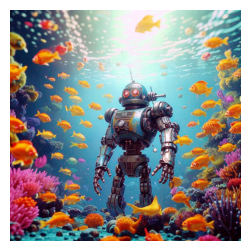

In [18]:
axplot(image)

# Понятие сверточный слой и сопутстсвующие операции.

Важно понимать, что свертка в сверточной сети работает не совсем так, как в классических подходах. Каждый набор карт признаков – это трехмерный тензор. Соответственно, каждое ядро свертки – это трехмерный тензор. Взаимодействие двух трехмерных тензоров создает одну выходную карту признаков. Для получения полной трехмерной выходной карты признаков нужно иметь набор трех-мерных ядер – четырех мерный тензор. При этом каждый трехмерный тензор имеет еще один параметр смещения. Это важно понимать, чтобы объяснить откуда у сети взялось нужное число параметров. Параметр смещения не всегда используется – его можно отключить.
Также можно представить, что результат свертки может быть с уменьшением размерности. Для избежания этого (если необходимо избегать) эффекта входное изображение условно дополняют нулями. Эта операция называет паддинг.

Различия между классическим сверточным слоем и традиционной сверткой с ядром приведены на рисунке ниже
<img src="https://github.com/MVRonkin/Deep-Learning-Foundation-Course/blob/main/2024/data/Auxiliary/Conv2d_to_Classic.png?raw=true" alt="Conv2d_to_Classic" title="Conv2d_to_Classic" width="950" />  




Для начала попробуем создать традиционную свертку, используя сверточный слой.

Для этого сначала запишим ядро фильтра в виде массива `NumPy`.

In [19]:
#Sharpen
kernel = np.array([[ 0, -1,   0],
                   [-1,  5,  -1],
                   [ 0, -1,   0]])

# kernel = np.array([[-3, -10, -3],
#                    [ 0,  0,   0],
#                    [ 3,  10,  3]])
print(kernel.shape)

(3, 3)


Теперь создадим экземпляр класса `nn.Conv2d` - нашу свертку. Для этого мы задаим:
* число входных каналов свертки (`in_channels`) - $3$,
* число выходных каналов свертки (`out_channels`) - также $3$,
* размер фильтра (`kernel_size`) = $3\times 3$, 
* шаг ядра (`stride`) = $1$,
* степень расширения свертки (`dilation`) =$1$,
* число групп (`groups`) = $3$,
* налчие параметра смещения (`bias`) - его нет.

Отметим, что в данном случае мы выставили число групп = 3. Это связано со спецификой операции свертка в `PyTorch`. В данном случае число групп равное числу каналов соотвествует тому, что применяемый фильтр воздействовать на каждый входной канал независимо. Если бы число групп было 1, то результат работы фильтра бы складывался для все входных каналов - что протеворечит классическому пониманию операции свертка. 

Тут также можно пояснить, что классчесое понимание операции свертка в большей степени соответствует т.н. [`depthwise convolution`](https://paperswithcode.com/method/depthwise-convolution).





Также, как это будет видно ниже, для нас будет важным число каналов в нашем изображении. 

In [20]:
channels = image.shape[0]

In [21]:
conv = nn.Conv2d(in_channels  = channels, 
                 out_channels = channels, 
                 kernel_size  = kernel.shape, 
                 stride       = 1, 
                 padding      = 1, 
                 dilation     = 1,
                 groups       = channels,
                 bias         = False)

Преобразуем ядро в формат, совместимый с `PyTorch`. Для этого сделам массив тензором, установим тип данных и размерность.

Класс  `nn.Conv2d` предполагает, что ядро будет $4-х$ мерным тензором вида: 
$$dim(\text{kernel}) = [\text{channels out}, \text{channels in}, \text{wide}, \text{height} ]$$. 
Для получения нужных размерностей  установим:
* Число выходных каналов $\text{channels out}=3$ 
* число входных каналов $1$ 
* число групп $3$, тем самым свертка превращается в $3$ отдельных канала - то есть сврточный слой становится тремя традиционными свертками.
* Каждый канал будет одинаковым.
* размер ядра $3\times 3$,
* шаг ядра $1$ пиксель, то есть ядро скользит по изображения пксель за пикселем.
* паддинг $1$ изображение дополняется рамкой из нулей размера $[kernel size//2]$ чтобы выход свертки имел тот же размер, что и вход.
* расширение свертки (`dilation`) выключено (равно $1$).
* смещение (`bias`) выключен.

Таким образом выходное ядро имеет в нашем случае размер $3 \times 1 \times 3 \times 3$.

Проведем также нормировку фильтра, так, чтобы сумма модулей всех его значений была равна 1. 



In [22]:
filter_ = torch.tensor(kernel).float()

norm = filter_.abs().sum()

filter_ = (filter_/norm).repeat(channels,1,1,1)
print(filter_.shape)

torch.Size([3, 1, 3, 3])


Задаим весовые параметры экземпляра свертка соответствующими нашему ядру. Для этого преобразуем веса в экземпляр класса `nn.Parameter`. Данная операция является требованием текущей версии `PyTorch`.

<!-- Операцию будем проводить с дерективой 
`torch.no_grad()`. -->

In [23]:
conv.weight = nn.Parameter(filter_)


Для выполнения операции свертка в ` PyTorch` необходимо:
* Привести входное изображение к виду $4-х$ мерного тензора формnа:     $$batch \times channels \times width \times height.$$ Для этого мы будем использовать операцию `unsqueeze`. После выполнения операции мы приведм размерность обратно при помощи обратной операции `squeeze`.
* Производится свертка. Результату вернем размер одонго изображения $$ channels \times width \times height.$$ 
* Результат операции преобразуем в тензор `NumPy` 
* Приведем результат к стандартному виду: диапазон значений $0...255$ (предполагается тип данных `uint8`). Для этого проведем стандартизацию результатов вида $$x' = 255\cdot\frac{x - min(x)}{max(x) - min(x)}.$$ Для выполнения данных процедурх запишим лямбда-выражение `standartize`.



In [24]:
image_torch = torch.unsqueeze(image, 0).float()
print(image_torch.shape)

torch.Size([1, 3, 1024, 1024])


Изображение в  `Torch` имеет формат $1 \times 3 \times 1024 \times 1024$.

Теперь проведем свертку и вернем результату размер одного изображения. Изображение стандартизируем.

In [25]:
img_out = conv(image_torch).squeeze(0)

standartize = lambda x: 255*(x - torch.min(x))/(torch.max(x)-torch.min(x))

for i in range(channels):
    img_out[i] = standartize(img_out[i])


Для визуализации результатов запишем функцию `axplot`. Данная функция будет выводить результа свертки, и, если необходимо, проводить эквивализации гистограммы. 

Также внутри функции мы проведм транспонирование размерностей чтобы привести их в соотвествие с ожидаемыми для бибилотеки визуализации `matplotlib`.

Последняя процедура часто делает результа визуализации более понятным. Для эквивализации используем преорбазования из библиотеки `torchvision`.

torch.Size([3, 1024, 1024])


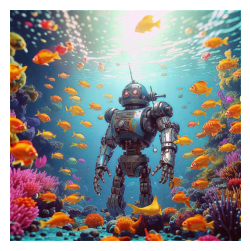

In [26]:
axplot(img_out,equlize = True)
print(img_out.shape)

Отметим также, что `PyTorch` также позволяет работать с частью своего функционала в процедурном стиле. Часть функций в данном стиле доступны в `torch.nn.functinal`, другие напрямую из `torch`. Приведем пример реализации свертки в фунциональном стиле и добавим к ней функии пулинга и активации в фунциональном стиле.

In [27]:
channels = image.shape[-3]
stride   = (1,1)
dilation = (1,1)
padding  = (dilation[0]*(kernel.shape[0]-1)//2,  
            dilation[1]*(kernel.shape[1]-1)//2) 

print(channels, padding)

3 (1, 1)


torch.Size([3, 512, 512])


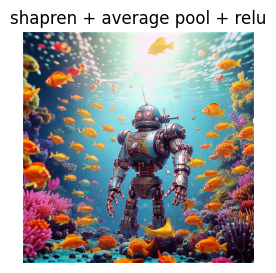

In [28]:
import torch.nn.functional as F

out = F.conv2d(input   = torch.unsqueeze(image,0).float(),
               weight  = filter_, 
               bias    = torch.zeros(filter_.shape[0]), 
               stride  = stride,
               padding = padding, 
               dilation= dilation, 
               groups  = channels)

out = torch.relu(out)
out = F.avg_pool2d(out,(2,2),stride=2)
out = out.squeeze(0)

for i in range(channels):
    out[i] = standartize(out[i])
    
axplot(out,equlize = True, title = 'shapren + average pool + relu')
print(out.shape)

Также попробуем добавить обратные операции, например билинейную интерполяцию (`bilinear_upsampling`).

torch.Size([3, 512, 512])
torch.Size([3, 1024, 1024])


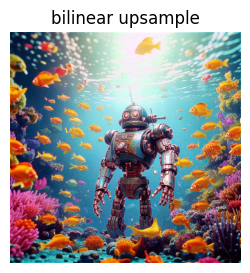

In [29]:
print(out.shape)
unpool = nn.UpsamplingBilinear2d(scale_factor=2)
out = unpool(out.unsqueeze(0)).squeeze(0)
print(out.shape)
axplot(out,equlize = True, title = 'bilinear upsample')

Также добавим возможность для регуляризации (нормализация или дроп-аут). Отметим, что в данном случае мы будем использовать т.н. `DropOut2D`, "выключающий" сразу по целому каналу.

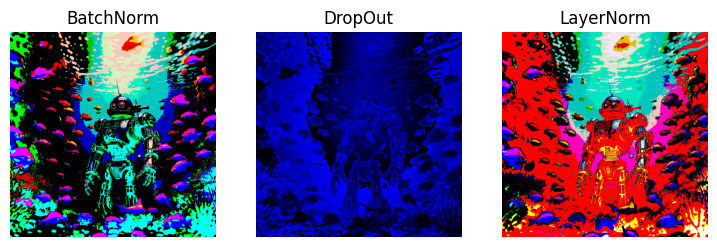

In [30]:
def regularization(norm_type = 'BatchNorm', shape=(3,512,512)):
    c,w,h = shape
    if norm_type == 'LayerNorm':
        return nn.LayerNorm((c,w,h))
    elif norm_type == 'BatchNorm':
        return nn.BatchNorm2d(c)
    elif norm_type == 'DropOut':        
        return nn.Dropout2d(p=0.4)
    

fig, axs = plt.subplots(1,3, figsize=(9,3))

img = torch.unsqueeze(image,0).float()
reg = regularization(norm_type = 'BatchNorm', shape = img.shape[1:])
axplot(reg(img).squeeze(0), ax=axs[0],title='BatchNorm') 


img = torch.unsqueeze(image,0).float()
reg = regularization(norm_type = 'DropOut', shape = img.shape[1:])
axplot(reg(img).squeeze(0), ax=axs[1],title='DropOut') 

img = torch.unsqueeze(image,0).float()
reg = regularization(norm_type = 'LayerNorm', shape = img.shape[1:])
axplot(reg(img).squeeze(0), ax=axs[2],title='LayerNorm') 




## Задания

__1.__ Проверьте результаты работы свертки для случаев:
* увеличенного шага свертки (`stride`);
* расширенной свертки (`dilation`) с разной степенью расширения;
* увеличенного шага свертки (`stride`) + `bilinear interpolation`;
* макпулинга вместо среднего пулинга
* замены `relu` на `sigmoid`
* произвольные комбинации модулей.

__2.__ Составьте функционал аугментации, заданный сверткой и изученными операциями.

__3.__ Проверьте результаты работы изученного функционала для `GrayScale` image.

<code style="color : red">__4.*__</code> Преобразуйте изученную свертку к стандартному сверточному слою и проверьте результаты его работы для рассмотренной классической операции.

# Аугментация набора данных

## Загрузка набора данных

Одним из наиболее действенных приемов регуляризации обучения является расширение выборки обучающих данных. Однако, расширение выборки реальными примерами не всегда возможно. Поэтому возникает желание расширить выборку «вручную». То есть при помощи искусственных приемов. Такой подход к регуляризации называется __[Аугментация данных](https://www.d2l.ai/chapter_computer-vision/image-augmentation.html) (Data Augmentation)__. 

Цель аугментации — создать похожие, но обучающие примеры данных. Для этого используются серии случайных изменений обучающих данных. В результате аугментация позволяет:
* Увеличить размер обучающего набора данных. 
* Случайные изменения обучающих примеров позволяют моделям меньше полагаться на заложенное в ограниченной выборке смещение, тем самым улучшая обобщающую способность модели. 
> Например, мы можем по-разному обрезать изображение, чтобы интересующий нас объект выглядел в разных положениях, тем самым уменьшая зависимость модели от положения объекта. 
* Другими словами, может быть промоделирован разброс условий получения изображений (например, можно менять яркость и цвет, чтобы уменьшить чувствительность модели к цвету). 

 

В `PyTorch` проблема аугментации для изображений решается при помощи модуля [`transforms`](https://pytorch.org/vision/0.9/transforms.html) из библиотеки [`torchvision`](https://pytorch.org/vision/stable/transforms.html). Однако, существуют и внешние библиотеки аугментаций, например, слеюущие.

* [`torchvision.transforms.v2`](https://pytorch.org/vision/main/transforms.html)
```python
    from torchvision.transforms import v2
    
    transforms = v2.Compose([
    v2.RandomResizedCrop(size=(28, 28), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.225]),
])
```
* [`Korina`](https://kornia.github.io/).

```python 
    import kornia

    transform = nn.Sequential(
        kornia.enhance.AdjustBrightness(0.5),
        kornia.enhance.AdjustGamma(gamma=2.),
        kornia.enhance.AdjustContrast(0.7),
    )

    images = transform(images)

```

* [`Albumentation`](https://albumentations.ai/).

```python
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    train_transform = A.Compose(
        [
            A.SmallestMaxSize(max_size=160),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.RandomCrop(height=128, width=128),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
    ]
)
```

А также ряд пакетов для аугментации данных других модальностей.

<!-- Рассмотрим набор данных [`CIFAR10`](https://www.cs.toronto.edu/~kriz/cifar.html), который в этот раз импортируется из пакета `torchvision.datasets`. Однако в отличии от классичесского рассмотрения тут мы преобразуем набор к уже изученному ранее формату векторов. Эту операцию можно проделать при помощи встроенных функций `torchvision`. -->
Рассмотрим набор данных [`FashionMNIST`](https://github.com/zalandoresearch/fashion-mnist), который в этот раз импортируется из пакета `torchvision.datasets`.

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms, datasets

In [32]:
transform_ = lambda x: x / 255.0
transform=transforms.Compose([
                              transforms.ToTensor(),
                              transform_, ])

При загрузке набора данных задаются стандартные преобразования `transforms`. Тренировочная часть и тестовая часть загружаются отдельно.

<blockquote>
    Если не удается скачать набор данных с ошбикой про ssl, то нужно раскомментировать код ниже.
</blockquote>

In [33]:
# import ssl
# ssl._create_default_https_context = ssl._create_stdlib_context

In [34]:
train_data = datasets.FashionMNIST('data', train=True,  download=True,  transform=transform)
# test_data  = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

100%|██| 26421880/26421880 [00:01<00:00, 16838362.57it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 444550.56it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|█████| 4422102/4422102 [00:00<00:00, 7636261.88it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17082497.62it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Полученный набор данных представляет собой итерируемый объект. Доступ к отдельным элементам такого датасета может быть получен как для списка. Каждый элемент представляет собой изображение (в нашем случае — вектор) и его метку.

In [35]:
# name_classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
name_classes = ['T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

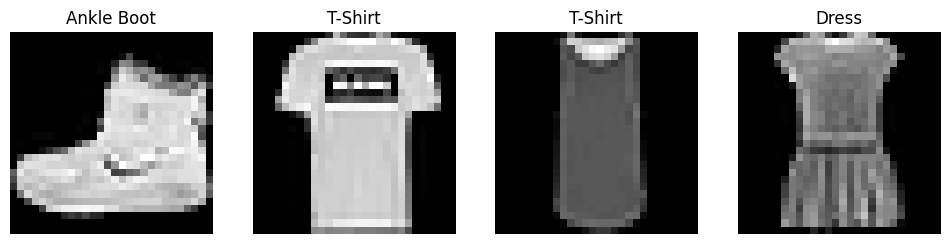

In [36]:
WIDTH = 28
HEIGH = 28
fig, axs = plt.subplots(1,4,figsize=(12,3));
for ax, dat in zip(axs.ravel(), train_data):
    ax.imshow(dat[0].view(WIDTH,HEIGH), cmap='gray'); 
    ax.set_title(name_classes[dat[1]]); 
    ax.axis('off')
plt.show()

In [37]:
BATCH_SIZE = 64
train_loader = data.DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)

In [38]:
images, _ =  next(iter(train_loader))
images.shape

torch.Size([64, 1, 28, 28])

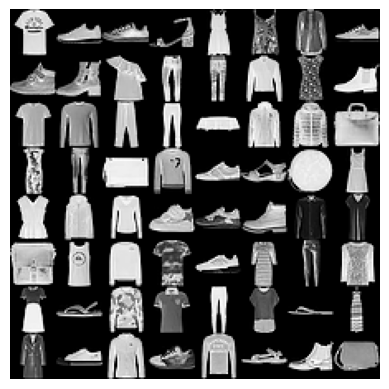

(torch.Size([64, 1, 28, 28]), torch.Size([3, 224, 224]), (224, 224, 3))

In [39]:
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape

## Теники аугментации в `PyTorch`

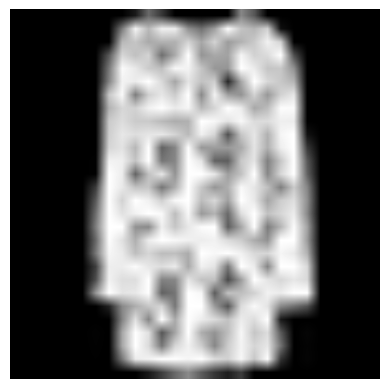

In [40]:
images, _ =  next(iter(train_loader))
images = images.reshape(-1,28,28)
images = images*255
images[0].shape
plt.imshow(images[0], cmap='gray', interpolation='bilinear');  plt.axis('off'); plt.show()

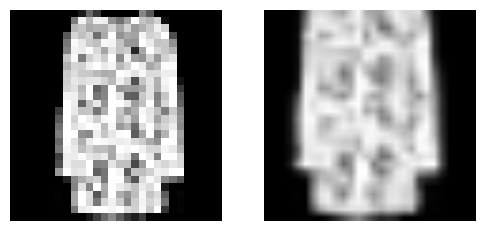

In [41]:
from PIL import Image
from torchvision import transforms 
plt.figure(figsize=(6,3))
to_pil = transforms.ToPILImage()

img = to_pil(images[0])
plt.subplot(121); plt.imshow(img, cmap = 'gray' ); plt.axis('off'); 

center_crops = transforms.Resize(size=32)(img) 
center_crops = transforms.RandomCrop(size=28)(center_crops) 

torch_image = transforms.ToTensor()(center_crops)
plt.subplot(122);  plt.imshow(torch_image[0,:,:], cmap = 'gray', interpolation='bilinear' ); plt.axis('off'); plt.show()


Часто одного типа аугментаций недостаточно. Важно смоделировать сразу набор факторов, влияющих на изображение. Более того, важно заметить, что каждую операцию аугментации часто проводят с заданной случайностью. 

/home/reshetnikov/miniconda3/envs/mmyolo/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


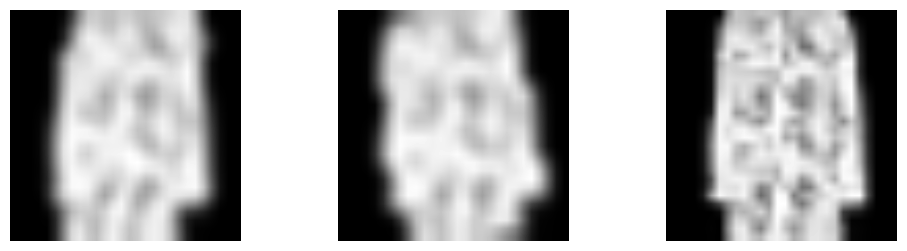

In [42]:
import torchvision.transforms as T

to_pil = T.ToPILImage()
img = to_pil(images[0])

padding = 1
kernel_size = 3

preprocess = T.Compose([
               T.ToTensor(),
               T.Resize(32),
               T.Pad(padding=padding), 
               T.CenterCrop(28),
               T.RandomRotation(degrees=10),
               T.RandomApply([T.GaussianBlur(kernel_size=kernel_size),
                              T.RandomPerspective(distortion_scale=0.6, p=0.3),],p=0.6),
                
                ])

plt.figure(figsize = (12,3))
for subplot in range(131,134):
    plt.subplot(subplot);plt.imshow(preprocess(img)[0,:,:], cmap='gray', interpolation='bilinear'); plt.axis('off')



Как правило, аугментацию проводят (данные генерируются) в процессе работы модели (то есть онлайн). Ниже показан пример добавления показанного выше пайплайна аугментации к загручику данных.

In [43]:
transform_ = lambda x: x.flatten().abs() / 255.0
trasforms = preprocess.transforms + [transform_]
transform=transforms.Compose(trasforms)

In [44]:
train_data = datasets.FashionMNIST('data', train=True,  download=True,  transform=transform)

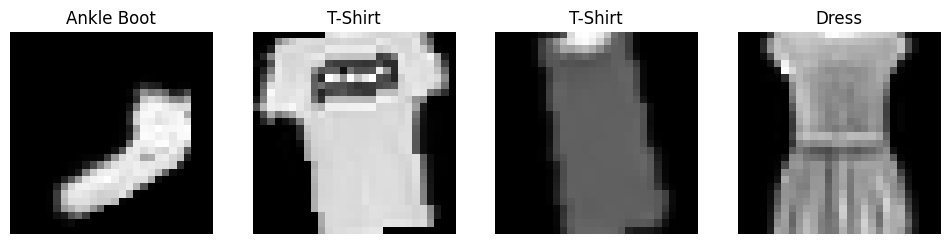

In [45]:
fig, axs = plt.subplots(1,4,figsize=(12,3));
for ax, dat in zip(axs.ravel(), train_data):
    ax.imshow(dat[0].view(WIDTH,HEIGH), cmap='gray'); 
    ax.set_title(name_classes[dat[1]]); 
    ax.axis('off')
plt.show()

Посмотрим на то, как теперь будет выглядеть батч данных.

In [46]:
BATCH_SIZE = 64
trainloader_ = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

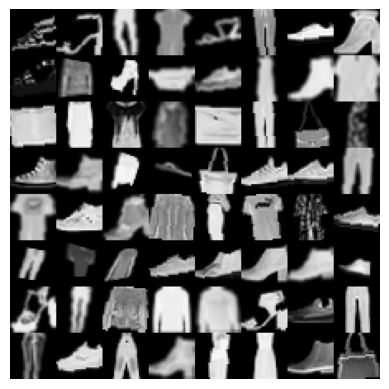

In [47]:
images, _ =  next(iter(trainloader_))
images = images.reshape(-1,1,28,28)
images *= 255
batch = torchvision.utils.make_grid(images, nrow = 8, padding = 0)
vis_batch = batch.numpy().transpose((1, 2, 0))
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()

## Задания

**1.** Аугментацию как правило используют только для тренировочной выборки. Однако, редко используют и на тестовой и валидационных выборках. Если такое практикуется, скорее всего, это необходимо для увеличения точности тестовой оценки. Однако, аугментация на тестовой выборке должна проводиться более аккуратно, чем на тренировочной. При начальном знакомстве с предметом «Глубокое обучение нейронных сетей» такая аугментация не рекомендуется. Поэтому __предлагаем__ слушателю разработать преобразования `transforms` отдельно для тестовой и отдельно для тренировочной выборок.

__2.__  Одна из главных проблем, связанных с использованием машинного обучения на [непроверенных данных](https://habr.com/ru/companies/wunderfund/articles/794546/) (в продолжительном режиме работы), заключается в риске возникновения т.н. __дрейфа модели__ (или __дрейфа данных__). *Дрейф модели* — это эффект снижения производительности модели при изменении распределения данных (при долговременном изменении признаков данных) в процессе работы. Например, для изображений камера может загрязняться, что приведет к размытию и появлению шумов типа *«соль и перец»* на изображениях. Или возникнет __эффект ограниченного набора данных__, то есть в реальных данных появятся/участятся случаи, не учтенные в тренировочных данных в достаточной степени. Например, если система обучена на наборе данных, который собран в течение одного сезона (напр., года), то этот набор данных может оказаться недостаточно полным для последующих годов. Другими словами, в данных появится значительная __нестационарность__. 

В целом проблема дрейфа решается путем постоянного сбора данных и их версионирования, а также путем постоянного обучения модели (непрерывного обучения). Однако, в данном случае __предлагается__ смоделировать возможные эффекты дрейфа данных путем аугментации данных. Проверьте, как это скажется на точности модели.


<code style="color : red">__3.*__</code> На самом деле как правило одного результата обучения не достаточно для того чтобы дать обоснованное заключение о точности работы модели. Поэтому часто проводят процедуру `k-folds` для получения менее смещенной оценки. В случае аугментации `k-folds` преобразования должны быть разными для валидируемой и тренировочной выброок. __Предлагается__ реализовать процедуру `k-folds` для `train_data` с аугментацией тренировочной выборки и без аугментации валидационной выборки.

<code style="color : red">__4.*__</code> Предлагается создать модель и обучить ее с аугментированной и не аугментированной тренировочной выборками. 

<code style="color : red">__5.*__</code> При обучении нейронных сетей важно не только обучение в заданных условиях, но и стабильность работы вне зависимости от внешних условий. При разработке и обучении моделей часто упускается из виду такой аспект, как безопасность и устойчивость перед нарушителем, желающего обмануть модель. [Вы можете быть удивлены](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html), обнаружив, что добавление незаметных возмущений к изображению может привести к радикальному изменению производительности модели. Поэтому при обучении модели важно понимать ее потенциальные уязвимости. Тогда можно добавить эти уязвимости в набор аугментации при тренировке модели, чтобы повысить устойчивость к ним. Такой подход называется `Adversarial Attack`. 

Самый простой пример `Adversarial Attack` может заключаться в добавлении к изображениям небольших шумов.  
> Отметим, что более сложная атака заключалась бы в следующем. Зная функцию потерь для модели, можно подобрать шумы так, чтобы их добавление ко входным данным максимизировало бы лосс, а следовательно, градиент значений, проходящих через модель. 

Предлагается слушателю на тестовом наборе данных добавить шумы (например, `torch.randn` или [другие типы](https://secml.readthedocs.io/en/stable/tutorials/06-MNIST_dataset.html#Training-of-the-classifier)) и проследить за точностью модели в зависимости от дисперсии этих шумов (то есть от т.н. `отношения сигнал-шум`).  
> Не забывайте, что у нас изображение нормировано в диапазон $[0,1]$. Поэтому после добавления шумов изображение стоит вернуть в нужный диапазон, например, при помощи `torch.clamp(perturbed_image, 0, 1)`.

<code style="color : red">__6.*__</code> Также для оценки надежности модели можно проверить ее работу для шумов. Проверим, что для обученной модели можно создать такое распределение нормального шума на входе, что ее выход будет классифицирован как заданное верное число с определенной долей уверенности.

In [48]:
from tqdm.notebook import trange

def imagine_digit(model, digit, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(BATCH_SIZE, 28, 28).reshape(BATCH_SIZE, 28*28)

            y_pred = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [51]:
DIGIT = 0

best_image, best_prob = imagine_digit(model, DIGIT)

NameError: name 'model' is not defined

In [50]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

plt.figure(figsize=(3,3)); plt.imshow(best_image.cpu().numpy().reshape(28,28), cmap='bone')
plt.axis('off');

NameError: name 'best_prob' is not defined

__Предлгагаем__ проверить то, как аугментация данных влияет не вероятность правильной классификации выборки нормального шума.

>Также __предлагаем__ провести анализ "на ошибки" результатов генерации шумовых изображений.